# Lecture 19: EM algorithm and alternating minimization

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture19.ipynb)

In this lecture, we'll look at the well known EM algorithm and alternating minimization for solving non-convex optimization problems.

Overview:

* [Alternating minimization](#am)
* [EM](#em)

Bibliographic notes: 

In [1]:
%matplotlib inline

#import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1)

from optimizers import gradient_descent
from projections import nuclear_projection
from plotters import convergence_plot, kwargs, setup_layout
setup_layout()

<a name="am"></a>

## Low-rank matrix factorization

In low-rank matrix factorization we're generally trying to solve an objective of the form

$$
\min_{\mathrm{rank}(M)\le k} f(M),
$$

where $f\colon\mathbb{R}^{m\times n}\to\mathbb{R}$ is a convex function. Note that the set of rank $k$ matrices forms a non-convex set.

In lecture 5, we saw that this problem can be attacked using the *nuclear norm relaxation* of the rank constraint. Projecting onto the unit ball of the nuclear norm was a costly operation that does not scale large matrices. We saw how to mitigate this problem using the Frank-Wolfe algorithm, in which the nuclear norm projection is replaced by a linear optimization step that is solved by the power method.

Here we'll see a natural approach to solve the non-convex formulation directly without any relaxation via *alternating minimization*.

### Alternating minimization

The idea behind alternating minimization is that a rank $k$ matrix $M$ can be written in factored form as $M=XY^\top,$ where $X\in\mathbb{R}^{m\times k}$ and $Y\in\mathbb{R}^{n\times k}$.

Given initial guesses $X_0,Y_0,$ we can then alternate between optimizing $X$ and optimizing $Y$ separately as follows:

For $t=1,\dots, T:$
* $X_t=\arg\min_{X} f(XY_{t-1}^\top)$
* $Y_t=\arg\min_{Y} f(X_t Y^\top)$

Since matrix multiplication is bilinear, the function $f(XY^\top)$ is convex in its argument $X$ and also convex in its argument $Y$.

In [2]:
def alternating_minimization(left, right, update_left, update_right,
                            num_updates):
    """Alternating minimization."""
    iterates = [(left, right)]
    for _ in range(num_updates):
        left = update_left(right)
        right = update_right(left)
        iterates.append((left, right))
    return iterates

Check out [this monograph](https://arxiv.org/abs/1712.07897) by Jain and Kar for a survey of convergence results for alternating minimization.

### Matrix completion

A common instance of this general problem is known as *matrix completion*. Here we have a partially observed matrix $m\times n$ matrix and we try to fill in its missing entries. This is generally impossible unless we make additional assumptions on the target matrix. A natural assumption is that the target matrix is close to low rank. In other words, the matrix is specified by far fewer than $mn$ parameters.

To set up some notation:
* We observe coordinates of an unknown matrix $A\in\mathbb{R}^{m\times n}$ specified by a set $\Omega.$
* We denote by $P_\Omega$ the coordinate projection of a matrix onto the set of entries in $\Omega.$
* We will denote by $\|\cdot\|_F$ the Frobenius norm.

The matrix completion objective can then be written as:

$$
\min_{X\in\mathbb{R}^{m\times k}, Y\in\mathbb{R}^{n\times k}}
\frac12\|P_{\Omega}(A-XY^\top)\|_F^2
$$

### Assumptions

To make the problem tractable, researchers rely on primarily two assumptions:

* Uniformly random samples: The entries of $\Omega$ are chosen independently at random.
* Incoherence: The entries of $A$ are "spread out" so that a random samples picks up a propertional share of $A$ with good probability. Formally, this can be achieved by assuming that the singular vectors of $A$ have small $\ell_\infty$-norm.

### Alternating updates for matrix completion

Here we'll compute the updates needed for alternating minimization via a naive direct solve in each row using the pseudoinverse. 

In other words, this approach takes advantage of the explicit form of $f$ as the Frobenius norm. While simple and slow when naively implemented, this approach, known as [Alternating Least Squares](https://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf) is popular because it is possible to create fairly efficient distributed versions of the algorithm.

Since both sides of the alternation are equivalent up to transposition, let's consider our problem for fixed $X$, solving for the least squares solution $Y$ in
$$
\min_{Y\in \mathbb{R}^{n\times k}}\frac{1}{2}\left\|P_{\Omega}(A-XY^\top)\right\|_F^2\,.
$$

Since the $i$-th row $\textbf{y}_i$ of $Y$ is the only component of $Y$ that appears in the $i$-th column of $P_{\Omega}(A-XY^\top)$, and the Frobenius norm is additive in matrix entries, we can optimize each row separately and combine them later to recover the solution to the joint problem over matrices $Y$; so fix $i\in[n]$ and consider
$$
\min_{\textbf{y}\in\mathbb{R}^k}\left\|\textbf{s}_i\times (\textbf{a}_i-X\textbf{y})\right\|_2^2\,,
$$
where $\textbf{a}_i$ is the $i$-th column vector of $A$ and $\textbf{s}_i$ is a binary vector corresponding to projection onto known entries $(\cdot ,i)\in \Omega$ (where above we use pointwise multiplication, but rewriting this as multiplication with a diagonal binary matrix we recover a cannonical least squares problem).

This means we need to solve $n$ $k$-dimensional-input $m$-dimensional-output least-squares problems. Since $\textbf{s}_i$ is binary, we can reduce the size of the output dimension of the least-squares problem by ignoring the entries that are zeroed out (reducing output dimension to $\left\|\textbf{s}_i\right\|_1$).

This approach is pretty slow when performed serially!. We could instead use any of the convex solvers we already saw. The advantage of a direct solve is that we have no additional hyperparameters to worry about. However, we can see that the independence of the $n$ subproblems would be amenable to a distributed implementation.

In [3]:
def update_right(A, S, X):
    """Update right factor for matrix completion objective."""
    m, n = A.shape
    _, k = X.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    # only over the nonzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in range(n):
        si = S[:, i]
        sia = A[si, i]
        siX = X[si]
        Y[i,:] = np.linalg.lstsq(siX, sia)[0]
    return Y

def update_left(A, S, Y):
    return update_right(A.T, S.T, Y)

We can now instantiate the general algorithm for our problem.

In [4]:
def altmin(A, S, rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.random.normal(0, 1, (m, rank))
    Y = np.random.normal(0, 1, (n, rank))
    return alternating_minimization(X, Y, 
                                    lambda Y: update_left(A, S, Y), 
                                    lambda X: update_right(A, S, X),
                                    num_updates)

Below is code to plot a matrix decomposition in a neat manner. Ignore this for now, unless you're really into matplotlib.

In [5]:
def plot_decomposition(A, U=None, V=None):
    """Plot matrix decomposition."""
    m, n = A.shape
    fig_height = 9
    fig_width = float(n)*fig_height/m
    
    cmap=plt.get_cmap('bwr')
    bounds=np.concatenate([np.linspace(-100,-4,1), np.linspace(-4,-0.005,114),
        np.linspace(-0.005,0.005,25), np.linspace(0.005,4,114),np.linspace(4,100,1)])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(fig_width, fig_height))
    
    rects = [[0.05,0.15,0.8,0.8],[0.825,0.15,0.1,0.8],[0.05,0.05,0.8,0.1]]
    
    ims = []
    for (rect, mat) in zip(rects, [A, U, V]):
        if type(mat)==type(None):
            break
        ax = fig.add_axes(rect)
        ims.append(
            ax.imshow(mat, cmap=cmap,norm=norm,interpolation='none'))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_tick_params(size=0)    
        ax.yaxis.set_tick_params(size=0)

    cbaxes = fig.add_axes([0.1, 0.01, 0.7, 0.05])
    plt.colorbar(ims[0], orientation='horizontal', cax=cbaxes)
    plt.show()

Let's see how alternating minimization works in a toy example.

In [6]:
def subsample(A, density):
    """Randomly zero out entries of the input matrix."""
    C = np.matrix.copy(A)
    B = np.random.uniform(0, 1, C.shape)
    C[B > density] = 0
    return C, B <= density    
    
def example1():
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros((40, 70))
    # Create rank 2 matrix with checkerboard pattern
    for i in range(0,40):
        for j in range(0,70):
            if divmod(i, 2)[1]==0:
                A[i,j] += -3.0
            if divmod(i, 2)[1]==1:
                A[i,j] += 3.0
            if divmod(j, 2)[1]==0:
                A[i,j] += 1.0
            if divmod(j, 2)[1]==1:
                A[i,j] += -1.0
    plot_decomposition(A)
    B, S = subsample(A, 0.25)
    plot_decomposition(B)
    results = altmin(A, S, 2, 10)
    for (U, V) in results:
        plot_decomposition(np.dot(U, V.T), U, V.T)        
    
    return

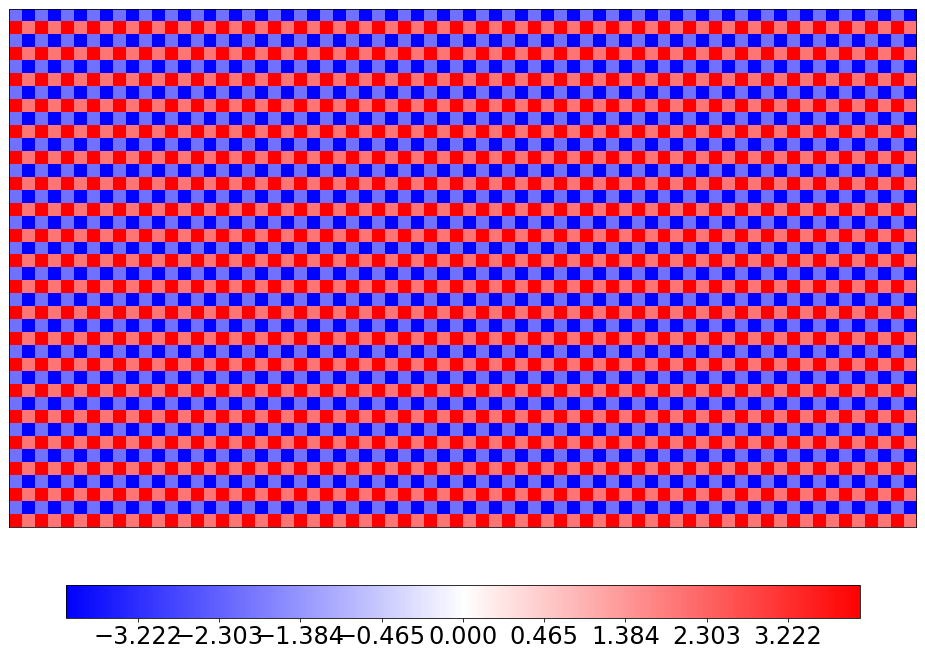

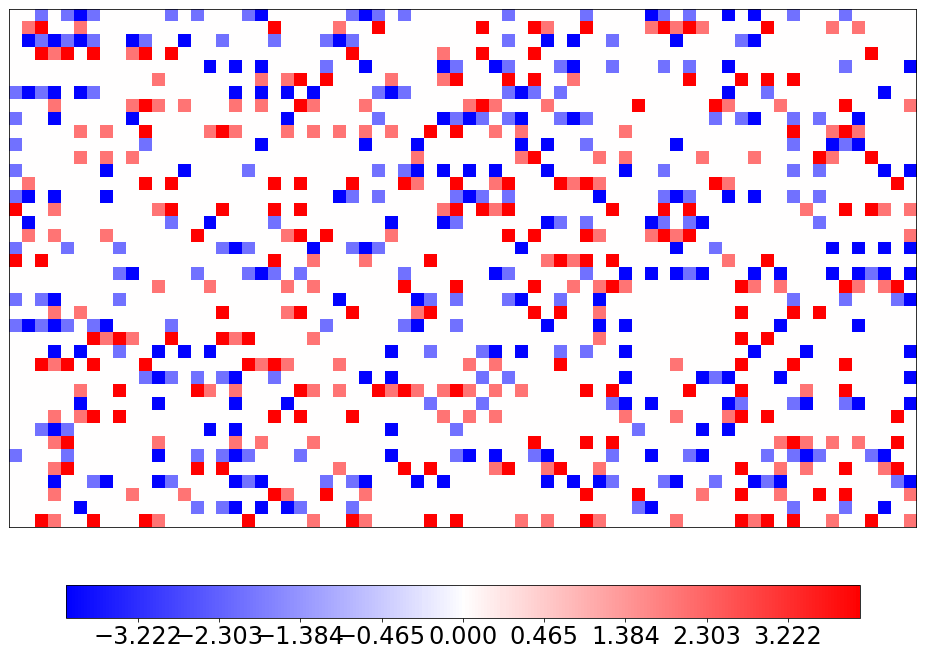

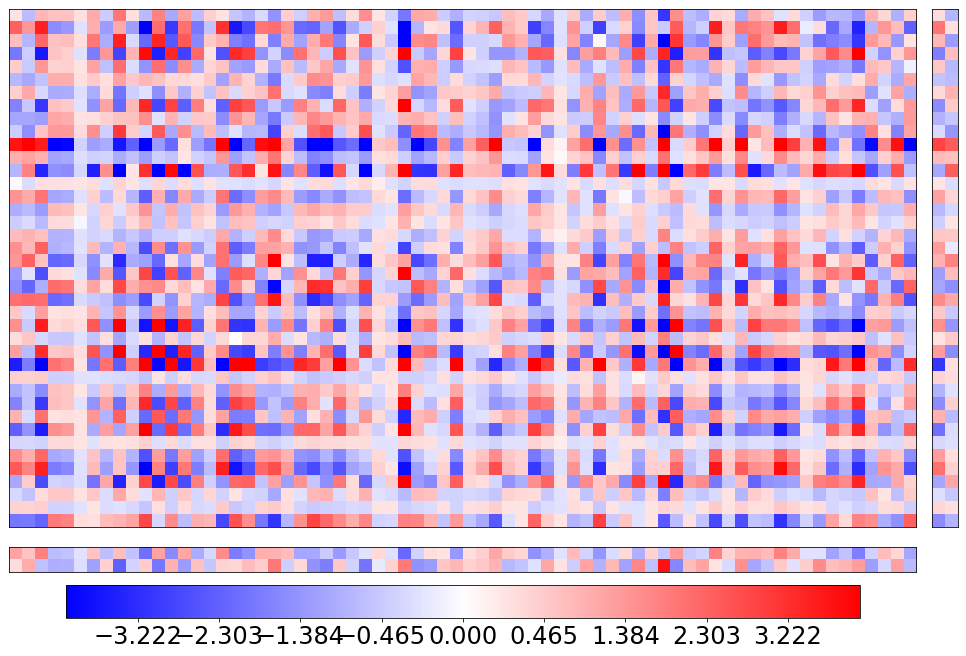

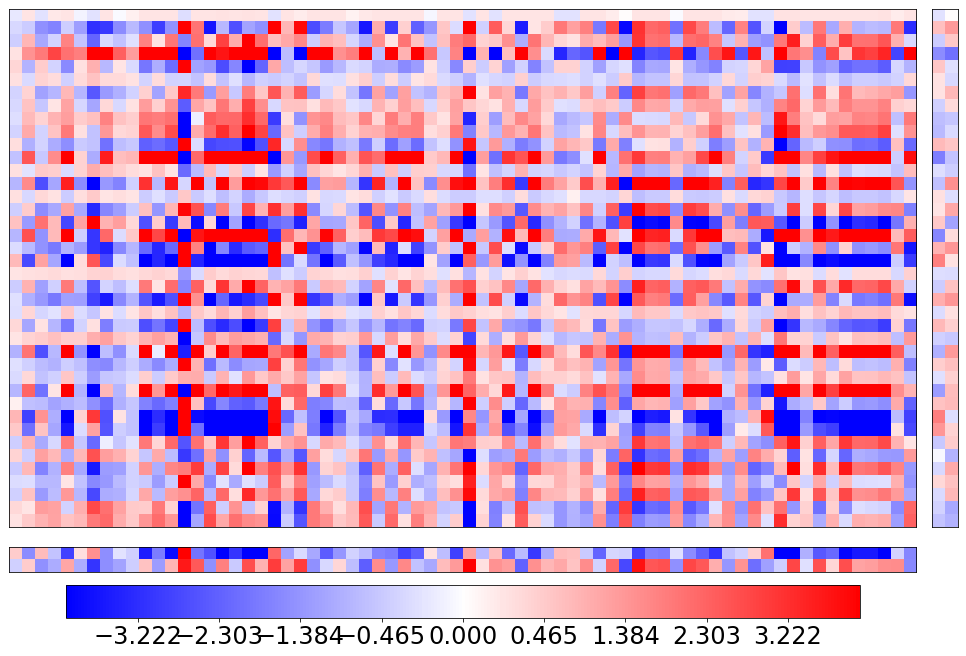

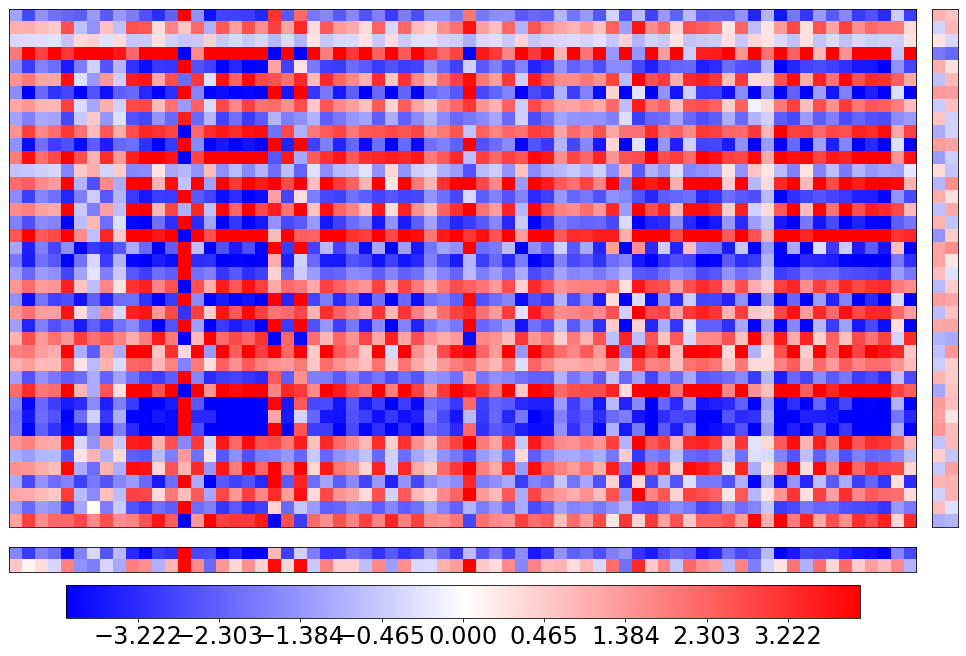

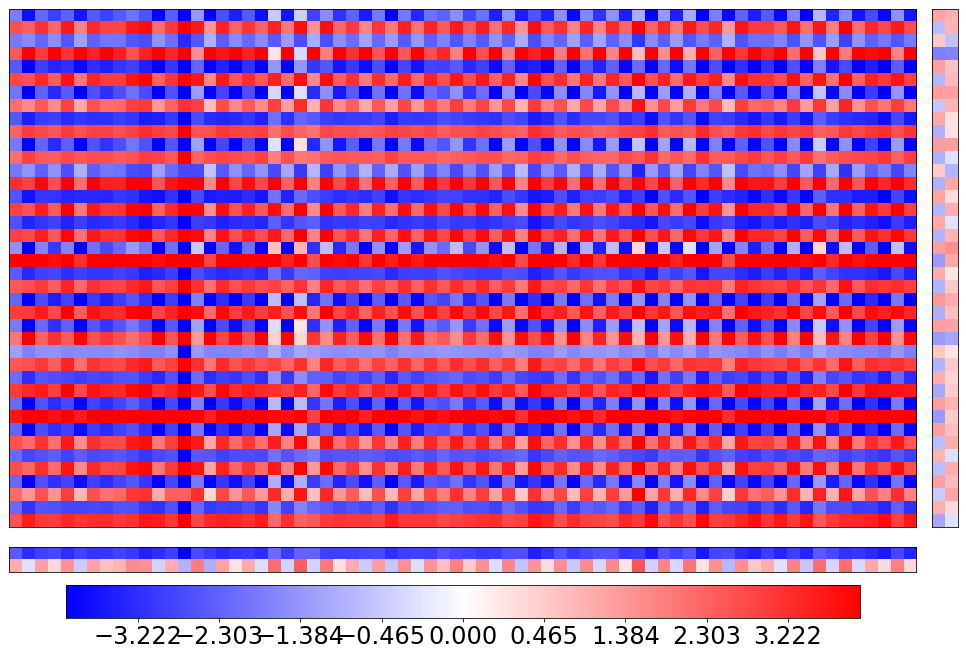

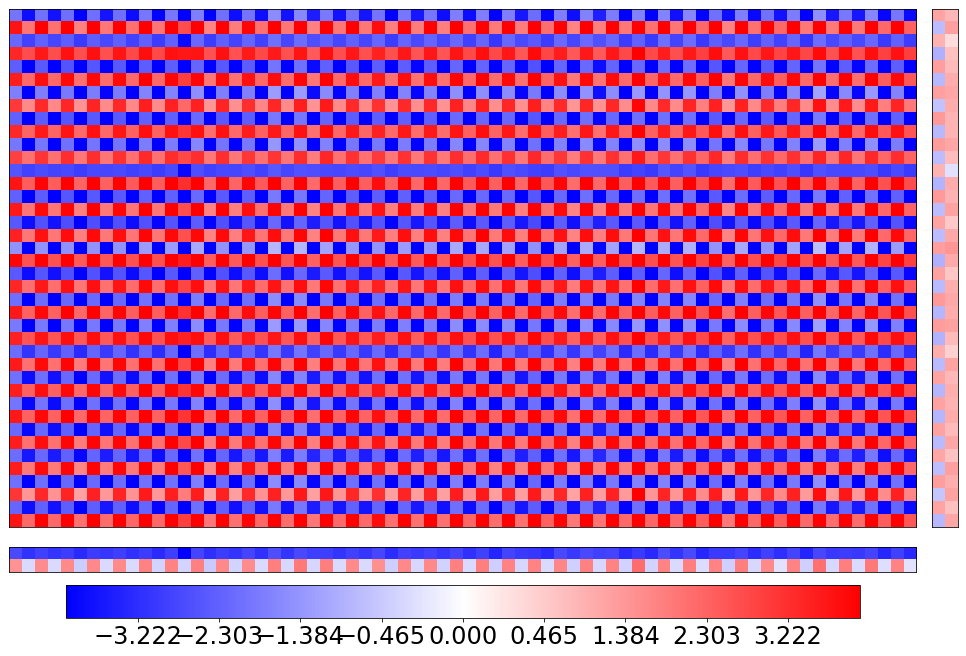

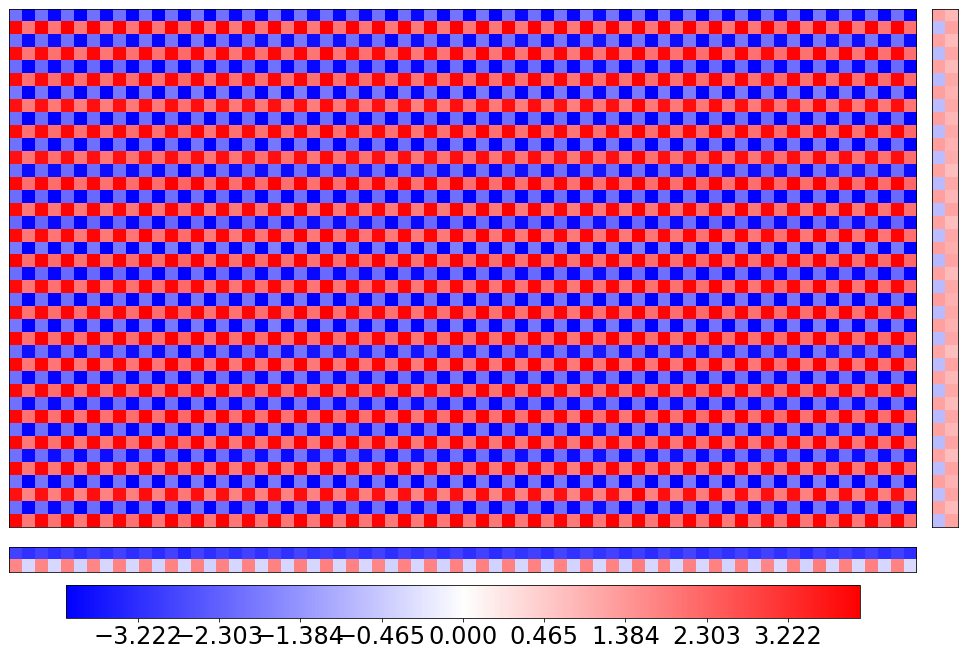

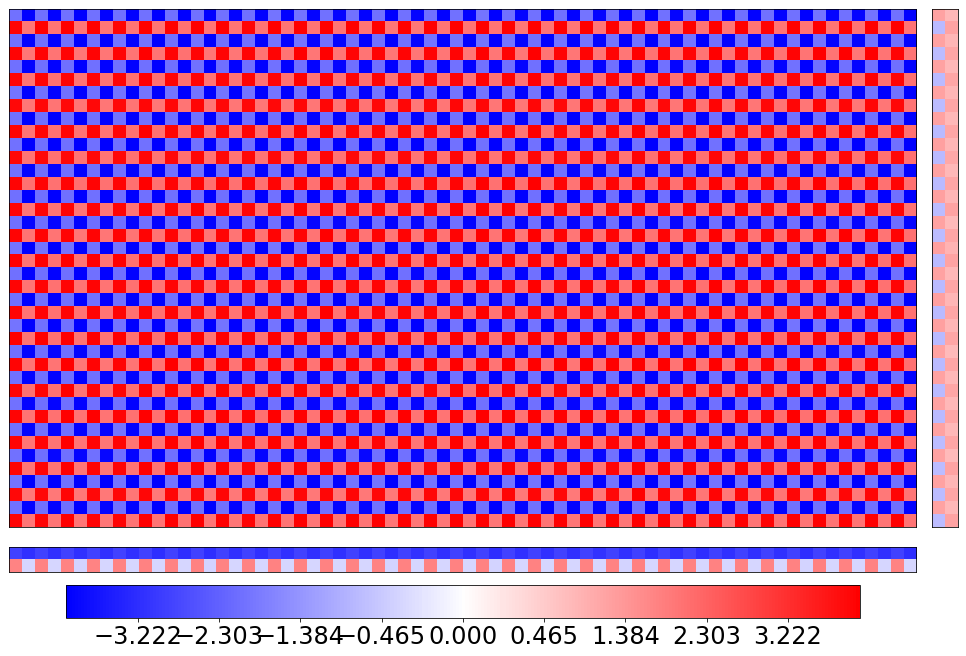

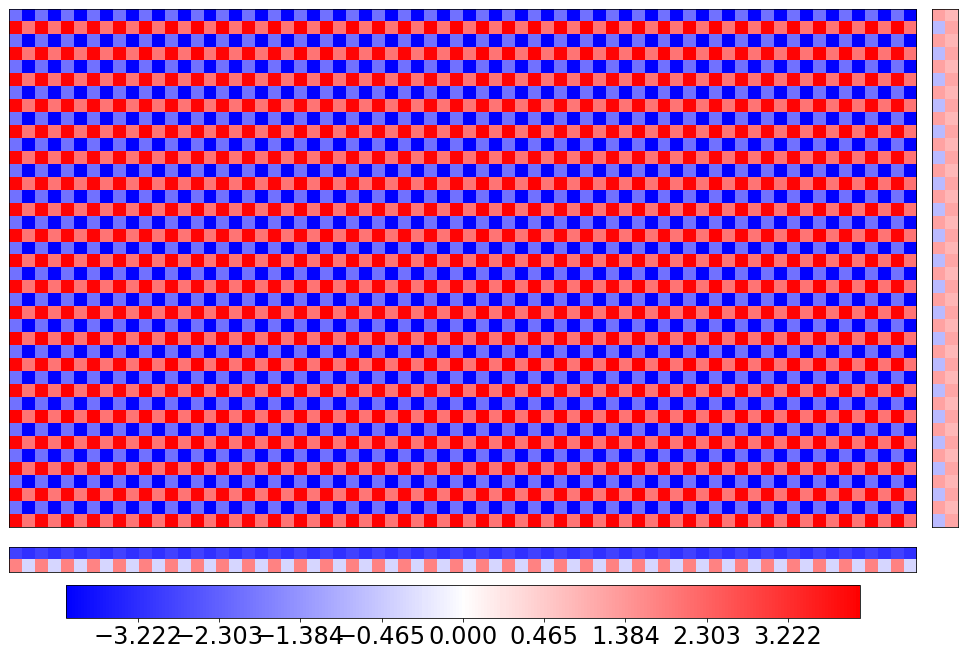

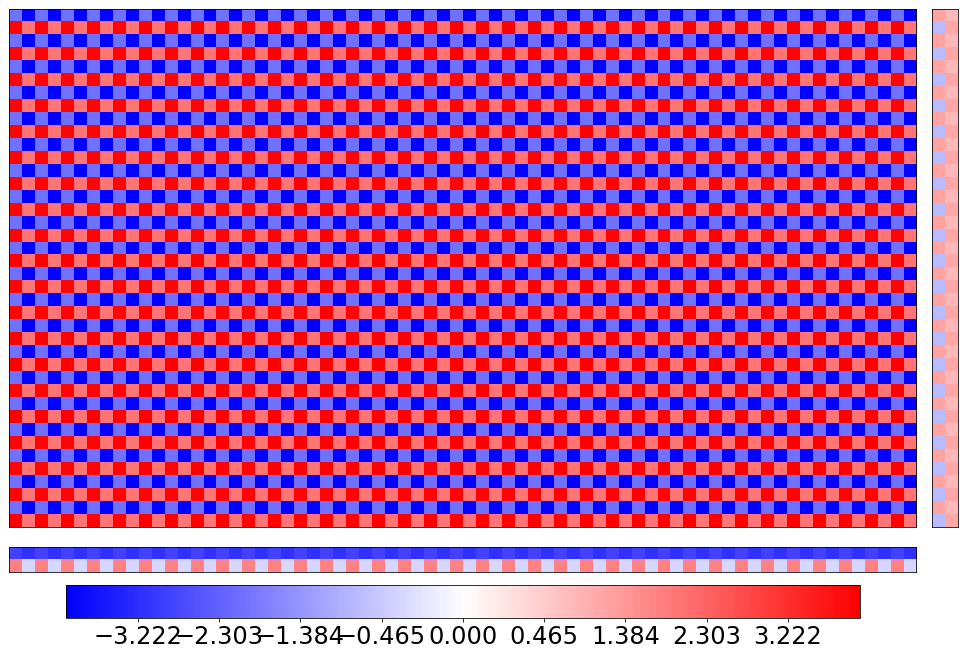

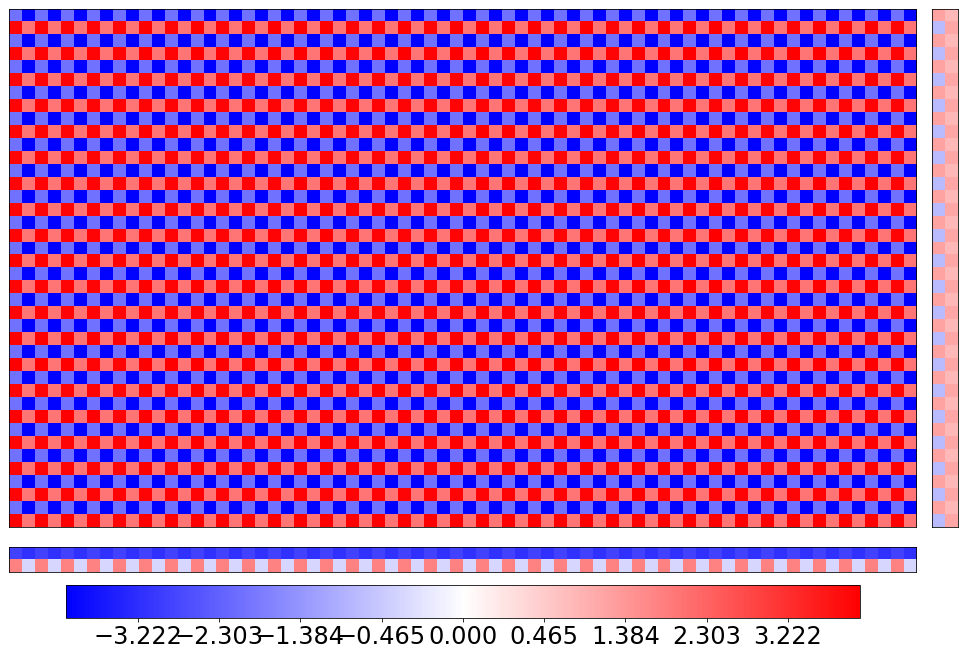

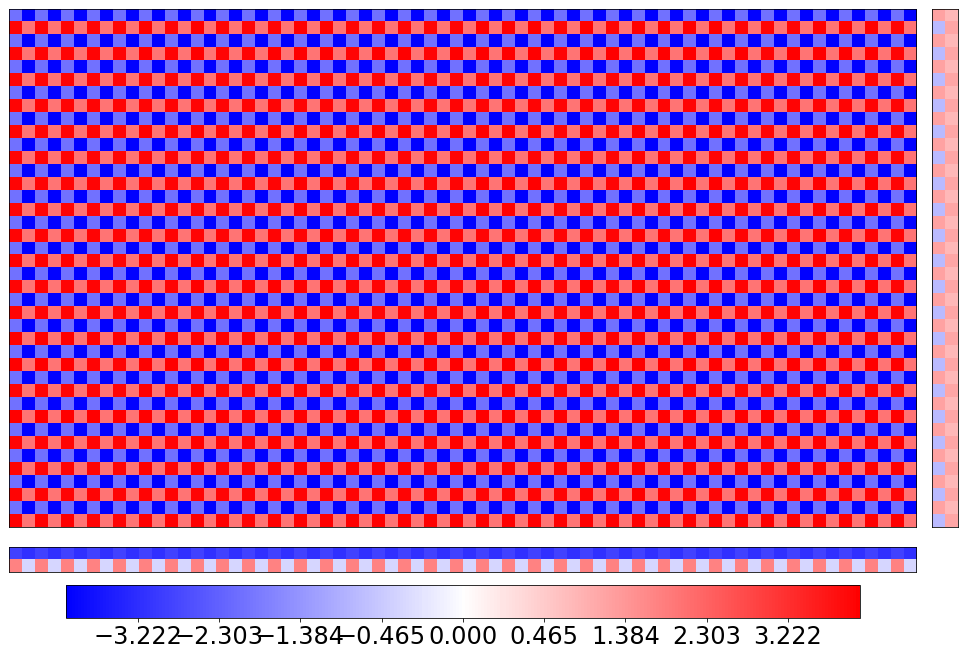

In [7]:
example1()

We see that after a few iterations, alternating minimization has found a good approximation. Restart this algorithm a few times to see that the convergence is affected strongly by the random initialization.

## Exercises

* Code up a more serious implementation that does not ever compute a full $m\times n$ matrix, but rather works with a given set of observed entries. Use stochastic gradient descent as a sub-routine for the updates.
* Do a running time analysis of the algorithm.

## Comparison with gradient descent and nuclear norm projection

Below is our example from Lecture 5.

In [8]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
L = np.diag(np.random.uniform(0, 1, k))
L /= np.sum(L)
A = U.dot(L.dot(U.T))
# pick which entries we observe uniformly at random
S = np.random.randint(0, 2, (n, n))
# multiply A by S coordinate-wise
# B = P_\Omega(A)
B = np.multiply(A, S)

def mc_objective(B, S, X):
    """Matrix completion objective."""
    # 0.5*\|P_\Omega(A-X)\|_F^2
    return 0.5 * np.linalg.norm(B-np.multiply(X, S), 'fro')**2

def mc_gradient(B, S, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, S) - B


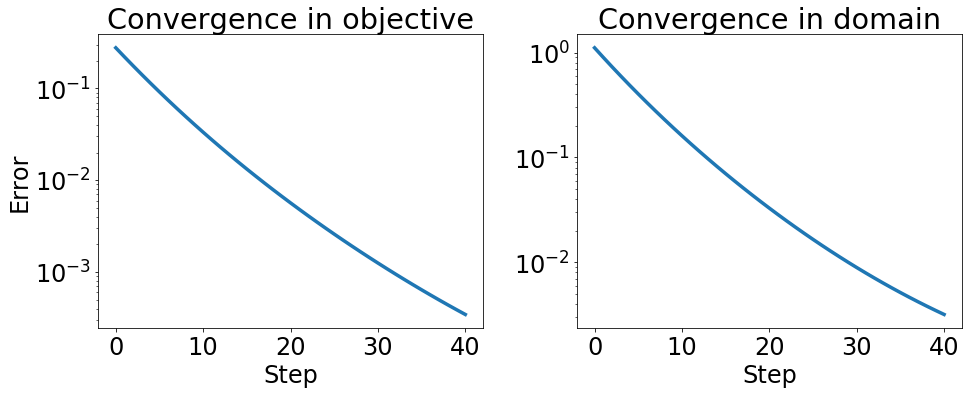

In [9]:
def example2():
    # start from random matrix of nuclear norm 1
    X0 = np.random.normal(0,1, (n,n))
    X0 = nuclear_projection(X0.dot(X0.T))
    objective = lambda X: mc_objective(B, S, X)
    gradient = lambda X: mc_gradient(B, S, X)
    Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)

    convergence_plot([objective(X) for X in Xs],
                    [np.linalg.norm(A-X, 'fro')**2 for X in Xs])
    
example2()

The algorithm was pretty slow even on this tiny example.

Below we compare it with a variant of alternating minimization that makes a single gradient step in each update. There are numerous natural variants depending on which optimizer we choose. A popular method involves stochastic updates that use only a single entry.

In [10]:
def mc_objective_factored(B, S, X, Y):
    """Matrix completion objective."""
    m, n = B.shape
    return 0.5 * np.linalg.norm(B-np.multiply(np.dot(X, Y.T), S))**2

def altmin_gd(rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    Y = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    iterates = [(X, Y)]
    for i in range(num_updates):
        X = X - grad(lambda X: mc_objective_factored(B, S, X, Y))(X)
        Y = Y - grad(lambda Y: mc_objective_factored(B, S, X, Y))(Y)
        iterates.append((X, Y))
    return iterates

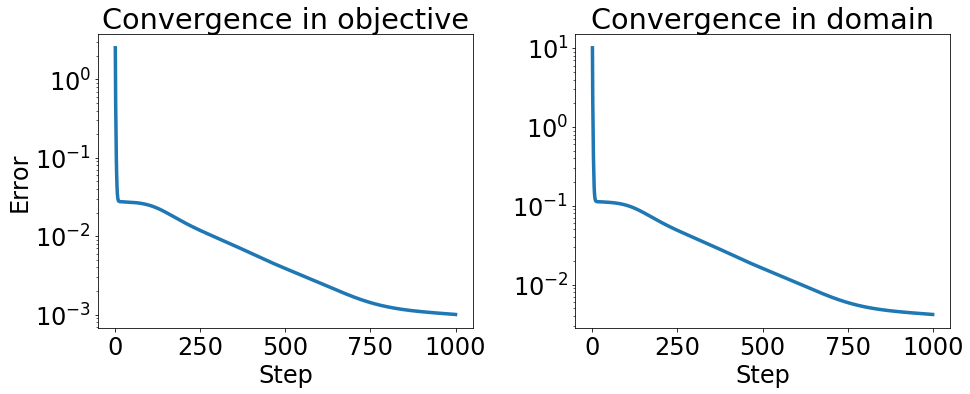

In [11]:
results = altmin_gd(10, 1000)
obj_values = [mc_objective_factored(B, S, X, Y) for (X, Y) in results]
dom_values = [np.linalg.norm(A-X.dot(Y.T), 'fro')**2 for (X, Y) in results]
convergence_plot(obj_values, dom_values)

The convergence behavior is pretty peculiar. It rapidly converges to the quality of the all zeros solution and then slows down substantially. We saw something similar happen to Frank-Wolfe.

In [12]:
mc_objective(B, S, 0)

0.028210546968991758

<a name="em"></a>

## EM

The Expectation-Maximization algorithm (EM) seek to find the maximum-likelihood estimator (MLE) of a parameterized model with missing latent values. In particular, consider a probibalistic model where the rv $X$ is observed, $Z$ is hidden, and $\theta$ is the parameter. Such a model is specified by $p(X,Z|\theta)$, a density when $X$ is continuous. In this case, the MLE is a maximizer of the log likelihood given the observed data (only $Z$ is integrated out),

$$
\max_\theta\mathbb{E}\left[\log p_\theta(X, Z)\,\middle|\,X\right]\,.
$$

Note that usually we have several observations, e.g., $X^{(i)},Z^{(i)}$ for some $i\in[n]$, but the log likelihood of these assumed-independent observations just gets added up we inspect the one-sample case for simplicity.

Many models are easy to specify jointly with latent variables. For example, the Gaussian mixture model with $K$ Gaussian has $Z$ take values in $[K]$ and $\theta$ as the concatenation of the parameters of the $K$ Gaussian parameters $\theta=\left\{\mu_i,\Sigma_i\right\}_{i=1}^K$ and the mixture weights $\pi$. The density of the point $(x,z)$ given a fixed $\theta$ is then just given by the normal PDF, so

$$
\log p_\theta(x, z)= \pi_z\log N(\mu_z,\Sigma_z)(x)\,.
$$

On the other hand, $\mathbb{E}\left[\log p_\theta(X, Z)\,\middle|\,X=x\right]$ is not nearly as pretty. EM transforms this potentially difficult immediate nonconvex optimization problem into usually easier alternating minimization problems. In the case of the Gaussian mixture models, these subproblems are actually convex and, better yet, have a closed-form solution.

### The EM Algorithm for Discrete Latent Variables

(Exposition follows Understanding Machine Learning: From Theory to Algorithms by Shai Shalev-Shwartz and Shai Ben-David)

We present the simplified EM algorithm for cases where $Z$ is discrete in $[K]$. Denote by $x_i$ the $i$-th iid observation of $X$, for $i\in[n]$.

We introduce the variable $Q$, an $n\times K$ matrix whose $iz$-th entry $q_{iz}$ will specify $p_\theta(z|x)$ for some fixed $\theta$. Namely, we split the aforementioned likelihood maximization into two steps, assuming some initial solution $Q^{(0)},\theta^{(0)}$. Then for $t>0$ the $t$-th iteration of EM is:

1. (Expectation). Set $q_{iz}^{(t)}=p_{\theta^{(t-1)}}(z|x_i)$
2. (Maximization). Set $\theta^{(t)}=\text{argmax}_\theta\,F(Q,\theta)$, where


$$
F(Q,\theta)=\frac{1}{n}\sum_i\sum_z q_{iz}\log p_\theta(x_i,z)\,.
$$

Since $Z$ is discrete it shouldn't be too hard to compute $p_{\theta^{(t-1)}}(z|x_i)$ with Bayes' rule and $ p_{\theta^{(t-1)}}(x_i,z)$, and the second optimization only relies on ease of optimization of the joint probability with respect to $\theta$. It's clear that EM does something easy in terms of computation, but to see that it's doing anything moderately useful we need to show it's an alternating maximization of the log likelihood $L(\theta)=\frac{1}{n}\sum_i\log \mathbb{E}\left[p_\theta(X, Z)\,\middle|\, X=x_i\right]$.

Indeed, define the function

$$
G(Q, \theta)=F(Q,\theta)-\sum_i \sum_z q_{iz}\log q_{iz}\,,
$$

over pairs where $Q\in \Delta_K^n$ (cartesian product of $n$ $K$-simplices) and $\theta$ is in the parameter space specified by the assumed probibalistic model.

It is possible to show that the EM algorithm is equivalent to the following two steps:

1. $Q^{(t+1)}=\text{argmax}_Q G(Q,\theta^{(t)})$
2. $\theta^{(t+1)}=\text{argmax}_\theta G(Q^{(t+1)},\theta)$

Further, one can show that $G(Q^{(t+1)},\theta^{(t)})=L(\theta)$ (see the reference section 24.4 at the top of this section for details). Then, since alternating maximization results in a non-decreasing sequence of iterates in $G$, the iterates $\theta^{(t)}$ must weakly improve $L$, giving us something with no guarantees but what generally works in practice for finding the MLE.

### Mixtures of Gaussians

We can apply the discrete EM algorithm above to a two-mean GMM (in the 1-dimensional case). Mathematical details are available on [Wikipedia](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Gaussian_mixture) and notes on the one-mean Gaussian MLE case, which captures most of the relevant calculus, are available [here](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter13.pdf).

In [13]:
import numpy as np
from scipy.misc import logsumexp

def em(e, m, X, theta, steps):
    thetas = [theta]
    n = len(X)
    for _ in range(steps):
        Q = e(X, theta)
        theta = m(Q, X)
        thetas.append(theta)
    return thetas

# X has dim n
# theta is comprised of a tuple of
# pi, a k mixture weight vector
# mu, a k-length mean vector
# sigma, a k-length standard deviation vector

def gmm_joint(X, theta):
    """
    returns an nxk matrix containing log p_theta(x_i, z) in the
    iz-th entry"""
    pi, mu, sigma = theta
    diffs = np.subtract.outer(X, mu) / sigma
    quadratic = -0.5 * diffs ** 2
    normalizing = -0.5 * np.log(2 * np.pi) - np.log(sigma)
    logpx_given_z = quadratic + normalizing
    # want p_\theta(z) * p_\theta(x|z) = p_\theta(x, z)
    return logpx_given_z  + np.log(pi)

def gmm_e(X, theta):
    joint = gmm_joint(X, theta)
    # want p_\theta(z|x) = p_\theta(x, z) / p_\theta(x)
    pz_given_x = np.exp(
        joint - logsumexp(joint, axis=1, keepdims=True))
    return pz_given_x

def gmm_m(Q, X):
    mixture_weight_sums = Q.sum(axis=0)
    pi = mixture_weight_sums / mixture_weight_sums.sum()
    mu = Q.T.dot(X) / mixture_weight_sums
    diffs = np.subtract.outer(X, mu)
    diffs *= Q
    sigma = np.sum(diffs ** 2, axis=0)
    sigma /= mixture_weight_sums
    return pi, mu, np.sqrt(sigma)

def gmm_likelihood(X, theta):
    joint = gmm_joint(X, theta)
    # want p_\theta(x) = sum_z p_\theta(x, z)
    # then also sum over xs for likelihood of all data
    return logsumexp(joint)

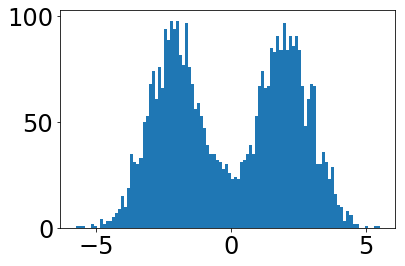

In [14]:
data = np.hstack([np.random.normal(-2, 1, 2000),
                  np.random.normal(2, 1, 2000)])
_ = plt.hist(data, bins=100)

In [15]:
np.percentile(data, [25, 75])

array([-2.07066455,  1.99583577])

In [16]:
# GMM mean init is actually important!
# people usually init with K-means, but for 1D sorting is ok
pi1 = np.random.uniform(0.25, 0.75)
theta = (
    [pi1, 1 - pi1],
    np.percentile(data, [25, 75]),
    np.random.uniform(0.5, 2, size=2))
thetas = em(gmm_e, gmm_m, data, theta, 20)

/home/mrtz/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


/home/mrtz/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


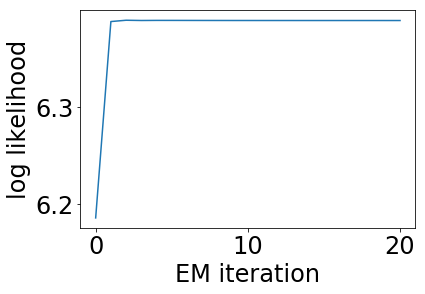

In [17]:
likelihoods = [gmm_likelihood(data, t) for t in thetas]
plt.plot(likelihoods)
plt.xlabel('EM iteration')
plt.ylabel('log likelihood')
plt.show()

('final means', array([-2.07772226,  1.99895332]))


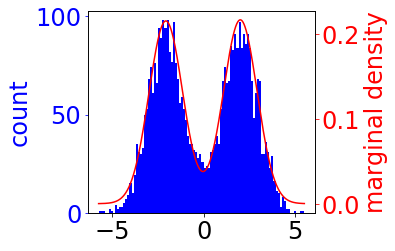

In [18]:
print('final means', thetas[-1][1])

fig, ax1 = plt.subplots()
ax1.hist(data, bins=100, color='b')
ax1.set_ylabel('count', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.set_ylabel('marginal density', color='r')
ax2.tick_params('y', colors='r')
xs = np.linspace(data.min(), data.max(), 10000)
ax2.plot(
    xs, np.sum(np.exp(gmm_joint(xs, thetas[-1])), axis=1),
    color='r')
fig.tight_layout()
plt.show()

<a name="kmeans"></a>

## k-means




Example courtesy of Jake Vanderplas:

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

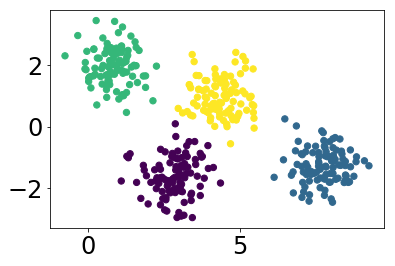

In [19]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

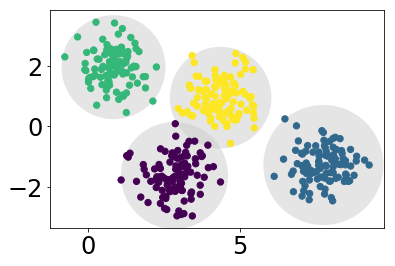

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

## That's it. Thanks.